__File: src_physics_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 23, 2020__

Testing some of the features of SRC-pairs from the standpoint of SRG operator evolution. The connection comes from looking at NN momentum distributions via the momentum occupation operator $a^{\dagger}_q a_q$ where we SRG evolve the operator and wave functions for a low-resolution description.

__Revision history:<br/>__
* Jul 10, 2020 - Reorganized by creating functions that generate the plots.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
import observables as ob
import operators as op
from Potentials.vsrg_macos import vnn
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

In [2]:
# Current working directory
cwd = getcwd()

__Deuteron momentum distribution $|\psi_d(k)|^2$__

In [3]:
def deuteron_momentum_distributions(kvnns, xlim=(0.0, 10.0), ylim=(1e-8, 1e3)):
    """
    Deuteron momentum distributions [fm^3] for several potentials splitting the S- and D-states with respect
    to momentum [fm^-1].
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Partial wave channel for deuteron is 3S1-3D1
    channel = '3S1'
    
    # Store momentum distibutions in dictionary
    d = {}

    # Calculate momentum distribution for each potential looping over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Set kvnn as key to dictionary
        d[kvnn] = {}

        # Load momentum and weights, Hamiltonian, and wave function
        k_array, k_weights = vnn.load_momentum(kvnn, '3S1')
        # Length of momentum array
        ntot = len(k_array)
        H_initial = vnn.load_hamiltonian(kvnn, '3S1')
        psi = ob.wave_function(H_initial)
        
        # Use this array to divide out integration factors
        factor_array = np.sqrt( 2*k_weights/np.pi ) * k_array
    
        # Calculate momentum distribution for S- and D-states
        uk_squared = ( psi[:ntot] / factor_array )**2
        wk_squared = ( psi[ntot:] / factor_array )**2
        
        # Store distributions in dictionary
        d[kvnn]['S'] = uk_squared
        d[kvnn]['D'] = wk_squared
        
        
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|\psi_d(k)|^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Subplot labels
    legend_size = 15
    legend_location = 'upper right'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, kvnn in enumerate(kvnns):
    
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
    
        # Plot S-state
        ax.semilogy(k_array, d[kvnn]['S'], color=curve_color, label=curve_label, linestyle='solid', linewidth=curve_width)
        # Plot D-state
        ax.semilogy(k_array, d[kvnn]['D'], color=curve_color, linestyle='dashed', linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

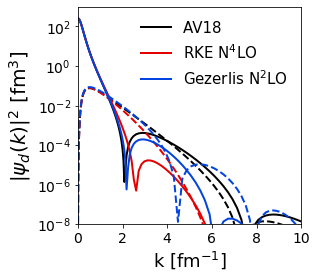

In [17]:
# # Check nodes of deuteron momentum distributions for S- and D-states with AV18, RKE N4LO 450 MeV, and Gezerlis N2LO 1 fm

# kvnns = (6, 111, 222)
# f, ax = deuteron_momentum_distributions(kvnns)

# # Save figure
# file_name = 'deuteron_dist_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

__Contributions to $<\psi_d|a^{\dagger}_q a_q|\psi_d>$__

In [5]:
def deuteron_integrand_contours_full(q, kvnn, generator, lamb, clim=(-8, -3)):
    """
    Plots SRG-evolved matrix elements of the momentum projection operator with some wave function [fm^5] with 
    respect to momentum [fm^-1]. This is an m x n contour plot where m is the size of generators and n is the 
    size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    eps : float, optional
        Energy value of the state [MeV]. Default is the deuteron (eps = -2.22 MeV).
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum power of the log-scaled colorbar (e.g. (-8, -3) means the colorbar
        spans 10^-8 to 10^-3).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = 2
    col_number = 2
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%d' % tick for tick in axes_ticks]
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    mx = -3
    mn = -8
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, mx-mn+1)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_norm = colors.LogNorm(vmin=mn, vmax=mx)
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    if generator == 'Block-diag':
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, lambda_bd=lamb)
    else:
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
    # Evolved momentum projection operator
    operator_init = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix, smeared=False)
    operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix, smeared=False)
#     operator = op.momentum_projection_operator(q, k_array, k_weights, channel, smeared=False)
            
    # Load evolved wave functions and divide out momentum and weights
    psi_init = ob.wave_function(H_initial, eps)
    psi = ob.wave_function(H_initial, eps, U=U_matrix)
    
    # TESTING
    ss_cont_i = abs( psi_init.T[:ntot] @ operator_init[:ntot, :ntot] @ psi_init[:ntot] )
    sd_cont_i = abs( psi_init.T[:ntot] @ operator_init[:ntot, ntot:] @ psi_init[ntot:] )
    ds_cont_i = abs( psi_init.T[ntot:] @ operator_init[ntot:, :ntot] @ psi_init[:ntot] )
    dd_cont_i = abs( psi_init.T[ntot:] @ operator_init[ntot:, ntot:] @ psi_init[ntot:] )
    total_i = ss_cont_i+sd_cont_i+ds_cont_i+dd_cont_i
    print(ss_cont_i/total_i*100)
    print(sd_cont_i/total_i*100)
    print(ds_cont_i/total_i*100)
    print(dd_cont_i/total_i*100)
    ss_cont = abs( psi.T[:ntot] @ operator[:ntot, :ntot] @ psi[:ntot] )
    sd_cont = abs( psi.T[:ntot] @ operator[:ntot, ntot:] @ psi[ntot:] )
    ds_cont = abs( psi.T[ntot:] @ operator[ntot:, :ntot] @ psi[:ntot] )
    dd_cont = abs( psi.T[ntot:] @ operator[ntot:, ntot:] @ psi[ntot:] )
    total = ss_cont+sd_cont+ds_cont+dd_cont
    print(ss_cont/total*100)
    print(sd_cont/total*100)
    print(ds_cont/total*100)
    print(dd_cont/total*100)
    
    # Mesh-grids of psi
    psi_row, psi_col = np.meshgrid(psi / factor_array, psi / factor_array)
        
    # Matrix elements of < psi | a^dagger_q a_q | psi >
    integrand = psi_row * (operator / row / col) * psi_col
    # Re-size
    integrand_ss = abs(integrand[:ntot, :ntot])
    integrand_sd = abs(integrand[:ntot, ntot:])
    integrand_ds = abs(integrand[ntot:, :ntot])
    integrand_dd = abs(integrand[ntot:, ntot:])
            
    # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_ss_int = ff.interpolate_matrix(k_array, integrand_ss, axes_max+0.2)
    k_array_int, integrand_sd_int = ff.interpolate_matrix(k_array, integrand_sd, axes_max+0.2)
    k_array_int, integrand_ds_int = ff.interpolate_matrix(k_array, integrand_ds, axes_max+0.2)
    k_array_int, integrand_dd_int = ff.interpolate_matrix(k_array, integrand_dd, axes_max+0.2)

    # Store in dictionary with generator and lamb as keys
    d['ss'] = integrand_ss_int
    d['sd'] = integrand_sd_int
    d['ds'] = integrand_ds_int
    d['dd'] = integrand_dd_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, char_i in enumerate(['s', 'd']):
        for j, char_j in enumerate(['s', 'd']):
            
            cc = char_i + char_j
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[cc], levels, norm=colors.LogNorm(),
                                   cmap=color_style, extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [6]:
# # Contours of momentum projection operator integrand with deuteron wave function using transformations from AV18

# q = 2.0
# kvnn = 6
# lamb = 1.0

# f, axs = momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22)

# label_size = 20
# label_location = 'lower right'
# for i, char_i in enumerate(['S', 'D']):
#     for j, char_j in enumerate(['S', 'D']):
#         label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
#         anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
#         axs[i, j].add_artist(anchored_text)

# file_name = 'deuteron_dist_contributions.png'
# chdir('Figures/SRC_physics')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [7]:
# q = 4.0
# kvnn = 6
# lamb = 1.0

# f, axs = momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22)

# label_size = 20
# label_location = 'lower right'
# for i, char_i in enumerate(['S', 'D']):
#     for j, char_j in enumerate(['S', 'D']):
#         label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
#         anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
#         axs[i, j].add_artist(anchored_text)

In [8]:
# q = 2.0
# kvnn = 222
# lamb = 1.0

# f, axs = momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22)

# label_size = 20
# label_location = 'lower right'
# for i, char_i in enumerate(['S', 'D']):
#     for j, char_j in enumerate(['S', 'D']):
#         label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
#         anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
#         axs[i, j].add_artist(anchored_text)

In [9]:
# q = 4.0
# kvnn = 222
# lamb = 1.0

# f, axs = momentum_projection_integrand_contours_full(q, kvnn, generator, lamb, eps=-2.22)

# label_size = 20
# label_location = 'lower right'
# for i, char_i in enumerate(['S', 'D']):
#     for j, char_j in enumerate(['S', 'D']):
#         label = r'$^3{\rm %s}_1$' % char_i + '-' + r'$^3{\rm %s}_1$' % char_j
#         anchored_text = AnchoredText(label, frameon=False, loc=label_location, prop=dict(size=label_size))
#         axs[i, j].add_artist(anchored_text)

__Ratio of SRG transformations: $U_{3S1}$ / $U_{1S0}$__

In [10]:
def srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, lambda_bd=0.00, xlim=(0.0, 2.5), 
                                      ylim=(1e-1, 2e3)):
    """
    Plots ratios of U(k, q_i)_{3S1} / U(k, q_i)_{1S0} with respect to momentum k [fm^-1] where k < \lambda or
    \Lambda_BD < q_points. This is a 1 x 1 semilog plot.
    
    Parameters
    ----------
    q_points : 1-D ndarray
        q values in the ratio U(k, q_i)_{3S1} / U(k, q_i)_{1S0} [fm^-1].
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis (which is log scale and unitless).
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set up --- #
    
    # Load momentum and weights (channel argument doesn't matter here)
    k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
    # Length of the momentum array
    ntot = len(k_array)
    
    # Divide out integration factors with factor_array
    factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
    row, col = np.meshgrid(factor_array, factor_array)
    # Same thing but for coupled-channel
    factor_array_cc = np.concatenate( (factor_array, factor_array) )
    row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)
    
    # Load initial and evolved Hamiltonians [MeV], and SRG transformations
    # 1S0
    H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
    H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    # 3S1
    H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
    H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
    # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
    # integration factors
    U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
    U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc
    
    
    # --- Calculate ratios --- #
    
    # Store results in dictionary where q_i values are the keys
    d = {}

    # Loop over q_i values
    for q_i in q_points:
    
        d[q_i] = {}
    
        # Index of q in k_array
        q_i_index = op.find_q_index(q_i, k_array)
        
        # Calculate |U(k, q_i)_{3S1}|^2
        numerator_array = U_matrix_3s1[:ntot, q_i_index] * U_matrix_3s1.T[q_i_index, :ntot] + \
                          U_matrix_3s1[:ntot, ntot+q_i_index] * U_matrix_3s1.T[ntot+q_i_index, :ntot]
        
        # Calculate |U(k, q_i)_{1S0}|^2
        denominator_array = U_matrix_1s0[:ntot, q_i_index] * U_matrix_1s0.T[q_i_index, :ntot]
        
        # Store ratio in dictionary
        d[q_i] = numerator_array / denominator_array
        
        
    # --- Plot ratios --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|U_{3S1}(k,q_i)|^2/|U_{1S0}(k,q_i)|^2$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'upper left'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over q_points keeping track of index
    for i, q_i in enumerate(q_points):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = r'$q_%d=%d$' % (i+1, q_i) + ' fm' + r'$^{-1}$'
        
        # Add curve to figure
        ax.semilogy(k_array, d[q_i], color=curve_color, label=curve_label, linestyle='solid', linewidth=curve_width)

    # Add horizontal line at 1
    ax.axhline(y=1, color='xkcd:black', linestyle='dotted')
        
    # Shade gray from \lambda or \Lambda_BD value to maximum momentum on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, lambda_bd, k_array[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, lamb, k_array[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [11]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and Wegner generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 6
# generator = 'Wegner'
# lamb = 1.0
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb)

# # Add potential and generator label
# kvnn_label = 'AV18'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [12]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and block-diagonal generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 6
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.5
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, lambda_bd)

# # Add potential and generator label
# kvnn_label = 'AV18'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [13]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for N2LO and Wegner generator

# q_points = np.array( (2.0, 4.0, 6.0, 8.0, 9.0 ) )
# kvnn = 222
# generator = 'Wegner'
# lamb = 1.0
# ylim = (1e-1, 1e4)
# f, ax = srg_transformation_ratios_fixed_q(q_points, kvnn, generator, lamb, ylim=ylim)

# # Add potential and generator label
# kvnn_label = 'N' + r'$^2$' + 'LO'
# generator_label = ff.generator_label_conversion(generator)
# full_label = kvnn_label + '\n' + generator_label
# label_size = 17
# label_location = 'upper right'
# anchored_text = AnchoredText(full_label, loc=label_location, prop=dict(size=label_size))
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_kvnn_%d_%s_q_points' % (kvnn, generator)
# for q_i in q_points:
#     file_name += '_%d' % q_i
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [14]:
def srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd=0.00, xlim=(0.0, 10.0), 
                                      ylim=(1e-1, 1e2)):
    """
    Plots ratios of U(k_0, q)_{3S1} / U(k_0, q)_{1S0} with respect to momentum k [fm^-1] where k_0 < \lambda or
    \Lambda_BD < q. This is a 1 x 1 semilog plot.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0, q)_{3S1} / U(k_0, q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (6, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis (which is log scale and unitless).
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set up --- #
    
    # Store results in dictionary where kvnns are the keys
    d = {}
    
    for kvnn in kvnns:
    
        # Load momentum and weights (channel argument doesn't matter here)
        k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
        # Length of the momentum array
        ntot = len(k_array)
    
        # Divide out integration factors with factor_array
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        row, col = np.meshgrid(factor_array, factor_array)
        # Same thing but for coupled-channel
        factor_array_cc = np.concatenate( (factor_array, factor_array) )
        row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)
    
        # Load initial and evolved Hamiltonians [MeV], and SRG transformations
        # 1S0
        H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
        H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
        # 3S1
        H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                             lambda_bd=lambda_bd)
    
        # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
        # integration factors
        U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
        U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc
    
        # Index of k_0 in k_array
        k_0_index = op.find_q_index(k_0, k_array)
        
        # Calculate |U(k_0, q)_{3S1}|^2
        numerator_array = U_matrix_3s1[k_0_index, :ntot] * U_matrix_3s1.T[:ntot, k_0_index] + \
                          U_matrix_3s1[ntot+k_0_index, :ntot] * U_matrix_3s1.T[:ntot, ntot+k_0_index]
        
        # Calculate |U(k, q_i)_{1S0}|^2
        denominator_array = U_matrix_1s0[k_0_index, :ntot] * U_matrix_1s0.T[:ntot, k_0_index]
        
        # Store ratio in dictionary
        d[kvnn] = numerator_array / denominator_array
        
        
    # --- Plot ratios --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$|U_{3S1}(k_0,q)|^2/|U_{1S0}(k_0,q)|^2$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'upper right'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns keeping track of index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        # Add curve to figure
        ax.semilogy(k_array, d[kvnn], color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Add horizontal line at 1
    ax.axhline(y=1, color='xkcd:black', linestyle='dotted')
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, 0.0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, fontsize=legend_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [15]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and Wegner generator

# k_0 = 0.1
# kvnns = (6, 222)
# generator = 'Wegner'
# lamb = 1.0
# f, ax = srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb)

# # Save figure
# file_name = 'srg_transformation_ratios_k_0_%.1f_%s_kvnns' % (k_0, generator)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name)
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

In [16]:
# # Plots ratios of  U(k, q_i)_{3S1} / U(k, q_i)_{1S0} for AV18 and Wegner generator

# k_0 = 0.1
# kvnns = (6, 222)
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.5
# f, ax = srg_transformation_ratios_fixed_k(k_0, kvnns, generator, lamb, lambda_bd)

# # Save figure
# file_name = 'srg_transformation_ratios_k_0_%.1f_%s_kvnns' % (k_0, generator)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name)
# chdir('Figures/SRC_physics')
# f.savefig(file_name + '.pdf', bbox_inches='tight')
# chdir(cwd)

__Slices of $U(k,q)$__

__Contours of $U(k,k')$__

__Ratios of $a^{\dagger}_q a_q$__

In [ ]:
# This is a consistency check on srg_transformation_ratios_fixed_k